Federated learning (FL) integration to enable distributed training of the model while ensuring data privacy and security.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Split dataset among 3 clients
def split_data(data, targets, num_clients):
    size = len(data) // num_clients
    return [(data[i*size:(i+1)*size], targets[i*size:(i+1)*size]) for i in range(num_clients)]

clients_data = split_data(x_train, y_train, 3)

# Build a CNN model
def create_cnn_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Initialize client models
client_models = [create_cnn_model() for _ in range(3)]
optimizers = [tf.keras.optimizers.Adam() for _ in range(3)]
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Federated averaging
def federated_averaging(models):
    global_weights = [model.get_weights() for model in models]
    new_weights = [np.mean([client_weights[layer] for client_weights in global_weights], axis=0)
                   for layer in range(len(global_weights[0]))]
    for model in models:
        model.set_weights(new_weights)

# Define metrics
metrics = {
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall()
}

def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Define train_model function
def train_model(model, optimizer, x, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
    epoch_loss_avg = tf.keras.metrics.Mean()
    for batch_x, batch_y in dataset:
        with tf.GradientTape() as tape:
            predictions = model(batch_x, training=True)
            loss = loss_fn(batch_y, predictions)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss_avg.update_state(loss)
    return epoch_loss_avg.result()

# Training loop
global_epochs = 100
for epoch in range(global_epochs):
    losses = []
    for client_data, model, optimizer in zip(clients_data, client_models, optimizers):
        x, y = client_data
        loss = train_model(model, optimizer, x, y)
        losses.append(loss)

    federated_averaging(client_models)

    # Evaluate the averaged model
    y_pred = []
    y_true = []
    for x, y in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32):
        predictions = client_models[0](x, training=False)
        y_pred.extend(tf.argmax(predictions, axis=1))
        y_true.extend(tf.argmax(y, axis=1))

    for name, metric in metrics.items():
        metric.update_state(y_true, y_pred)

    precision = metrics['precision'].result().numpy()
    recall = metrics['recall'].result().numpy()
    f1 = calculate_f1_score(precision, recall)
    average_loss = np.mean(losses)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32)).numpy()

    print(f"Global Epoch {epoch+1}: Loss = {average_loss}, Accuracy = {accuracy}, Precision = {precision}, Recall = {recall}, F1-Score = {f1}")

    # Reset metrics for the next epoch
    for metric in metrics.values():
        metric.reset_states()

# Test final model performance
final_loss, final_accuracy = client_models[0].evaluate(x_test, y_test)
print(f"Final Model: Loss = {final_loss}, Accuracy = {final_accuracy}")


Global Epoch 1: Loss = 0.3725675046443939, Accuracy = 0.6402999758720398, Precision = 0.9137791395187378, Recall = 0.9998891353607178, F1-Score = 0.9548967536499223
Global Epoch 2: Loss = 0.2871287763118744, Accuracy = 0.9745000004768372, Precision = 0.9990014433860779, Recall = 0.9982261657714844, F1-Score = 0.9986136411928881
Global Epoch 3: Loss = 0.1315055936574936, Accuracy = 0.9811000227928162, Precision = 0.9994440674781799, Recall = 0.996563196182251, F1-Score = 0.9980015793382141
Global Epoch 4: Loss = 0.09795280545949936, Accuracy = 0.9853000044822693, Precision = 0.999444305896759, Recall = 0.9970066547393799, F1-Score = 0.9982240274993605
Global Epoch 5: Loss = 0.08160554617643356, Accuracy = 0.9872999787330627, Precision = 0.9995555281639099, Recall = 0.9973392486572266, F1-Score = 0.9984461382036166
Global Epoch 6: Loss = 0.0678454339504242, Accuracy = 0.9879999756813049, Precision = 0.9994446635246277, Recall = 0.9976718425750732, F1-Score = 0.9985574548075727
Global Epo

100


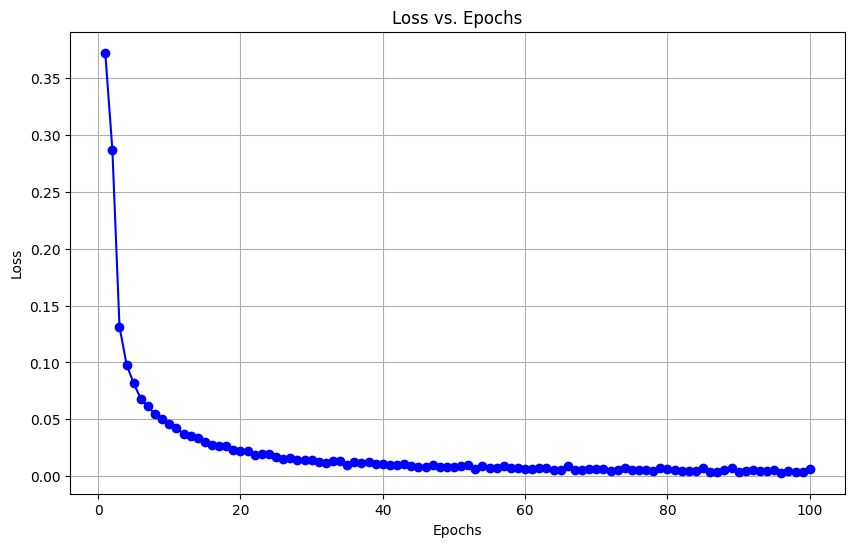

In [ ]:
import matplotlib.pyplot as plt

loss_values = [
    0.3725675046443939, 0.2871287763118744, 0.1315055936574936, 0.09795280545949936,
    0.08160554617643356, 0.0678454339504242, 0.06128604710102081, 0.054320141673088074,
    0.050348978489637375, 0.04545901343226433, 0.041953470557928085, 0.037229787558317184,
    0.03554021939635277, 0.0334593765437603, 0.02985907532274723, 0.027030250057578087,
    0.026599250733852386, 0.026205306872725487, 0.022845730185508728, 0.02167552150785923,
    0.022275425493717194, 0.018946843221783638, 0.019328856840729713, 0.019662639126181602,
    0.01685827039182186, 0.014935187995433807, 0.01612197794020176, 0.01441286038607359,
    0.01433761790394783, 0.014035634696483612, 0.012785169295966625, 0.011452890932559967,
    0.013035375624895096, 0.013224338181316853, 0.009740256704390049, 0.012106464244425297,
    0.011386538855731487, 0.012023095041513443, 0.010392938740551472, 0.010994556359946728,
    0.009464145638048649, 0.009632899425923824, 0.010489649139344692, 0.00926292035728693,
    0.007932846434414387, 0.008282923139631748, 0.01004090066999197, 0.007992345839738846,
    0.007578267250210047, 0.008385795168578625, 0.00863026175647974, 0.009445355273783207,
    0.00639377674087882, 0.008696280419826508, 0.006790280807763338, 0.007144097238779068,
    0.009107505902647972, 0.007335285190492868, 0.007166307419538498, 0.006149573717266321,
    0.005864344071596861, 0.0072976890951395035, 0.007141588721424341, 0.005307823419570923,
    0.005740663502365351, 0.008436344563961029, 0.005675558000802994, 0.005144054070115089,
    0.006656342651695013, 0.006092697381973267, 0.006487456616014242, 0.004899471066892147,
    0.005782937631011009, 0.007114098872989416, 0.005692304577678442, 0.005677568260580301,
    0.005477376282215118, 0.004648846108466387, 0.007125347387045622, 0.00629504956305027,
    0.00494869751855731, 0.004495004657655954, 0.004681355319917202, 0.0048213680274784565,
    0.006775314453989267, 0.003950893878936768, 0.0037660691887140274, 0.005097856745123863,
    0.007303415331989527, 0.003982807509601116, 0.004209910985082388, 0.005258588120341301,
    0.004388978239148855, 0.004251576494425535, 0.0057072825729846954, 0.002954016672447324,
    0.004883175250142813, 0.003708423348143697, 0.0031865639612078667, 0.005890627857297659
]
print(len(loss_values))

# Epochs (x-axis)
x = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, loss_values, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')

# Display the plot
plt.grid(True)
plt.show()

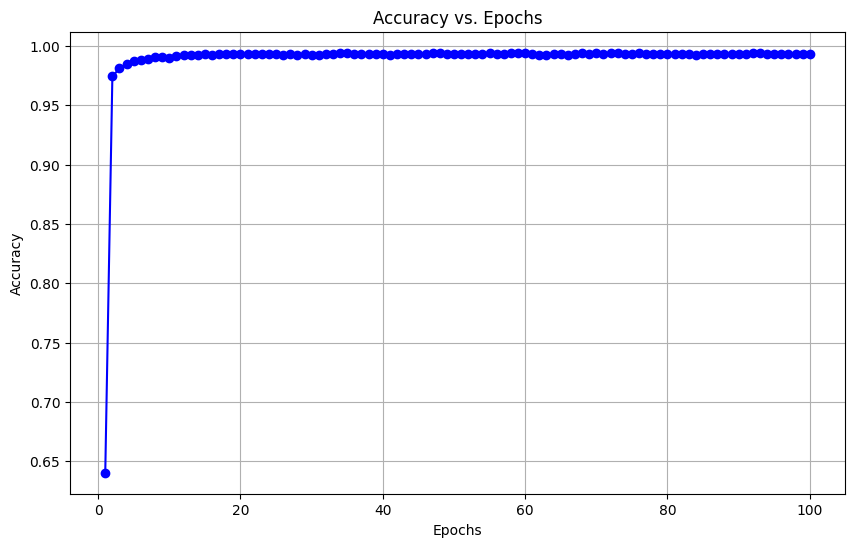

In [ ]:
import matplotlib.pyplot as plt

accuracy_values = [
    0.6402999758720398, 0.9745000004768372, 0.9811000227928162, 0.9853000044822693,
    0.9872999787330627, 0.9879999756813049, 0.9894999861717224, 0.9911999702453613,
    0.991100013256073, 0.9901999831199646, 0.9916999936103821, 0.9923999905586243,
    0.9925000071525574, 0.9927999973297119, 0.9930999875068665, 0.9927999973297119,
    0.9930999875068665, 0.9936000108718872, 0.9937000274658203, 0.9930999875068665,
    0.9932000041007996, 0.993399977684021, 0.9930999875068665, 0.993399977684021,
    0.9934999942779541, 0.992900013923645, 0.9933000206947327, 0.9926000237464905,
    0.9930999875068665, 0.9922000169754028, 0.9923999905586243, 0.9933000206947327,
    0.9930999875068665, 0.9940000176429749, 0.9937999844551086, 0.9933000206947327,
    0.9929999709129333, 0.9937000274658203, 0.9933000206947327, 0.9936000108718872,
    0.9926000237464905, 0.9934999942779541, 0.9933000206947327, 0.9936000108718872,
    0.9936000108718872, 0.993399977684021, 0.9940000176429749, 0.9940999746322632,
    0.9933000206947327, 0.9933000206947327, 0.9932000041007996, 0.9932000041007996,
    0.9937000274658203, 0.9934999942779541, 0.9943000078201294, 0.993399977684021,
    0.9930999875068665, 0.9940000176429749, 0.9944000244140625, 0.9940999746322632,
    0.9934999942779541, 0.992900013923645, 0.992900013923645, 0.9933000206947327,
    0.9933000206947327, 0.992900013923645, 0.9932000041007996, 0.9940000176429749,
    0.9936000108718872, 0.9937999844551086, 0.9932000041007996, 0.9937999844551086,
    0.9940999746322632, 0.993399977684021, 0.9933000206947327, 0.9937999844551086,
    0.9936000108718872, 0.9932000041007996, 0.9930999875068665, 0.9937000274658203,
    0.9936000108718872, 0.9936000108718872, 0.9936000108718872, 0.992900013923645,
    0.9937000274658203, 0.9932000041007996, 0.9937000274658203, 0.9937000274658203,
    0.9930999875068665, 0.9936000108718872, 0.9929999709129333, 0.9937999844551086,
    0.9939000010490417, 0.9937000274658203, 0.9936000108718872, 0.9936000108718872,
    0.9932000041007996, 0.9932000041007996, 0.9937000274658203, 0.9932000041007996
]



# Epochs (x-axis)
x = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, accuracy_values, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

# Display the plot
plt.grid(True)
plt.show()